# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1.2 Parameters Setting 

In [3]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'       # Define coherence type
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  20              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01                  #A-priori belief on word probability
random_state  = 12345     #Either a randomState object or a seed to generate one. Useful for reproducibility.
lemmatization = 1                  #Whether implement corpus lemmatization 1:yes 0:no

## 1.3 Corpus Reading 

In [4]:
df = pd.read_csv("NewChunkAll-STRIP-ASCII.csv", header = None)

In [6]:
len(df)

23147

## 1.4 Data Processing

Word number: 23147


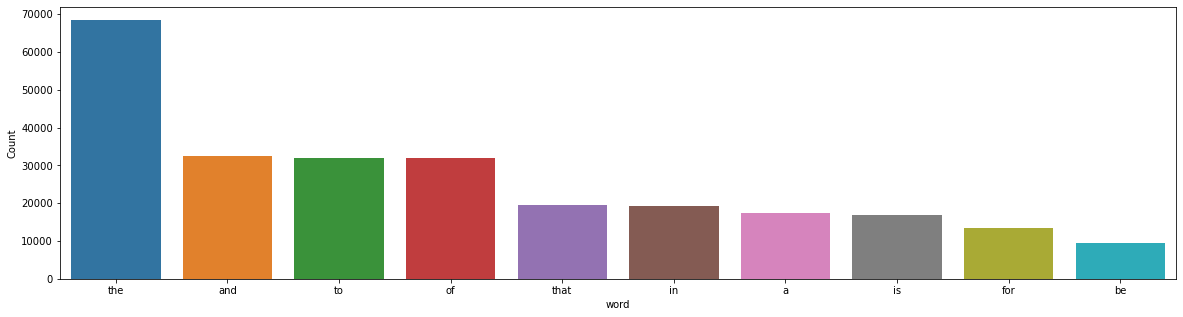

In [7]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Word number: %d'% (len(df[col])))
freq_words(df[2],10) 

<ipython-input-8-03fde7e31d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = df[col][i].lower()
<ipython-input-8-03fde7e31d6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = tokenizer.tokenize(df[col][i])


Tokens number: 19326


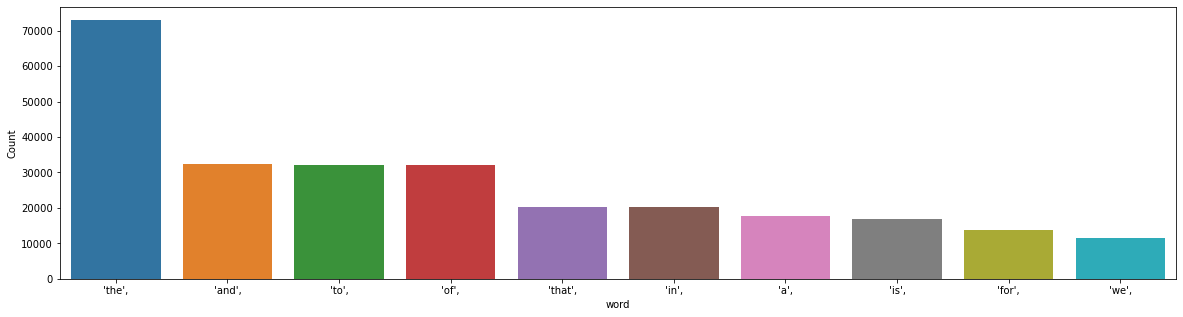

In [8]:
#Tokenize the corpus 
tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(df)):
    df[col][i] = df[col][i].lower()
    df[col][i] = tokenizer.tokenize(df[col][i])

print('Tokens number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing number: 19133


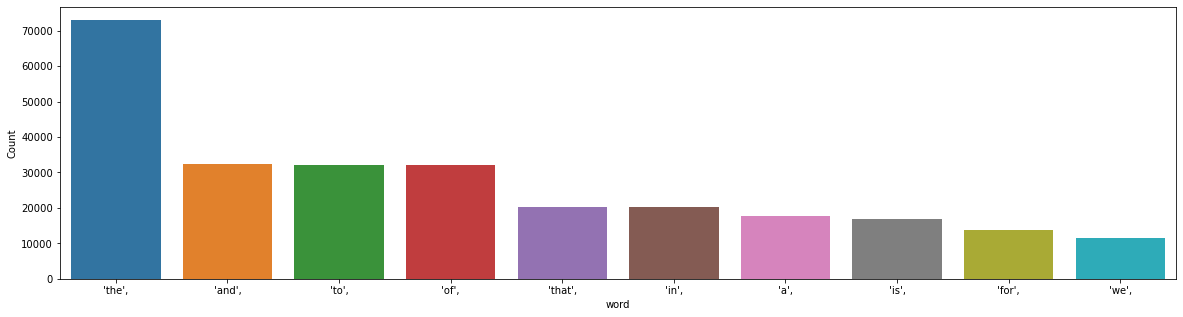

In [9]:
#Remove the number
df[col] = [ [token for token in doc if not token.isnumeric()] for doc in df[col]]

print('Tokens number after removing number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing stop words: 18997


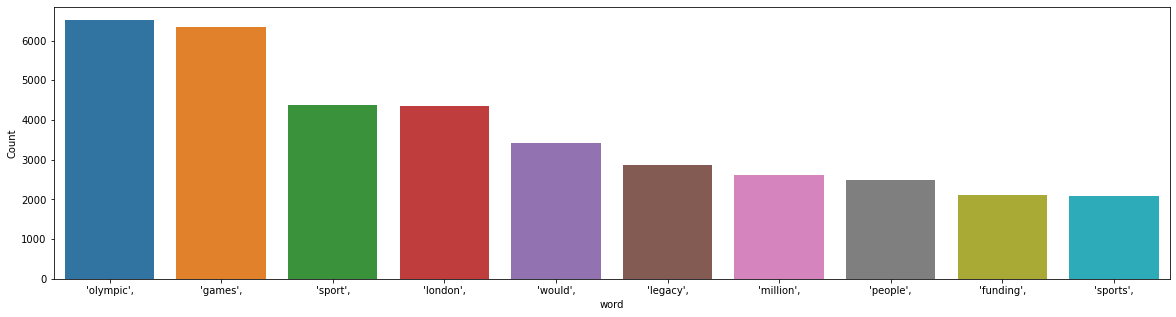

In [10]:
#Reomve stop words
stop_words = stopwords.words('english')
df[col] = [ [token for token in doc if not token in stop_words] for doc in df[col] ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing short words: 18261


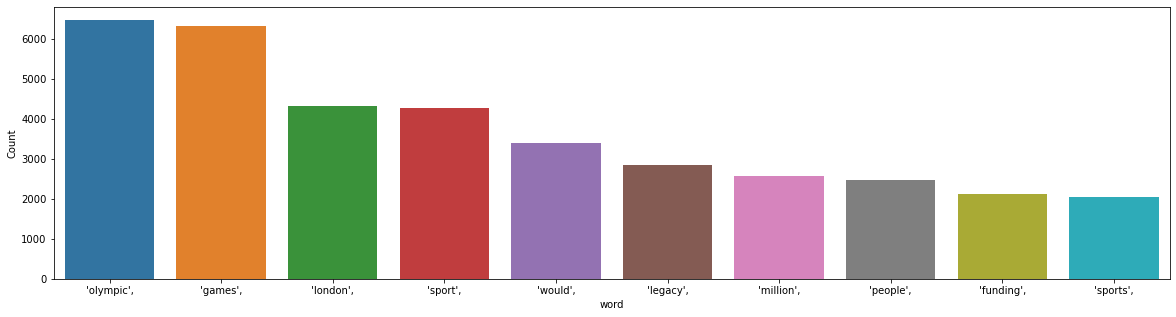

In [11]:
#Remove short words (length< min_len)
df[col] = [ [token for token in doc if not len(token) < min_len] for doc in df[col] ]
print('Tokens number after removing short words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

<ipython-input-12-c7354924e8a9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lemmatize_sentence(df[col][i])


Tokens number after lemmatization: 15631


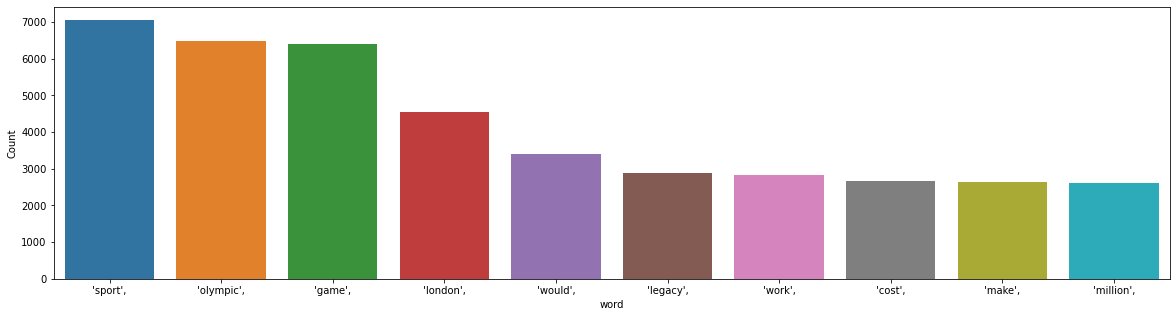

In [12]:
# Corpus Lemmatization
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(sentence):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res

if lemmatization == 1:
    for i in range (len(df)):
        df[col][i] = lemmatize_sentence(df[col][i])

print('Tokens number after lemmatization: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after adding bigram: 16581


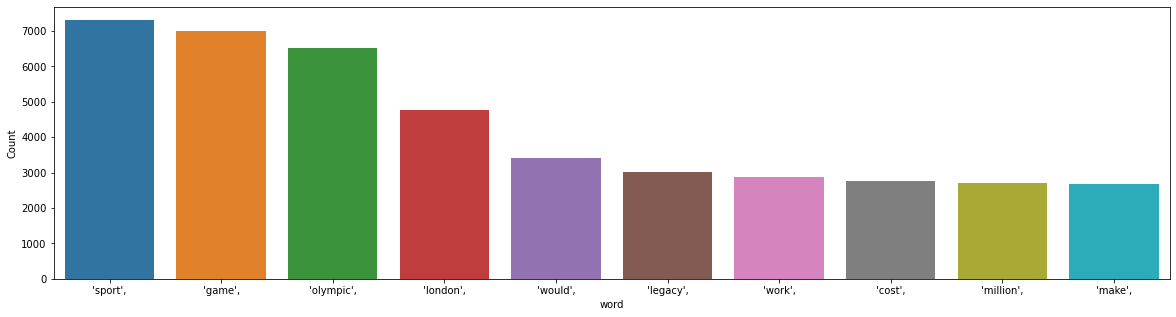

In [13]:
# Make bigram
bigrams_phases = Phrases(df[col], min_count = 10)
for i in range(len(df[col])):
    for token in bigrams_phases[df[col][i]]:
        if '_' in token:
            df[col][i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

## 1.5 The LDA Model Building

In [15]:
# Build a dictionary
LOdict = Dictionary(df[col])

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 16581


In [16]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 9754


In [21]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in df[col]]

In [22]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [23]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)

In [24]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = df[col], dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score ', coherence_type,'=', coherence_lda, ' with number of topics=', num_topics)

Coherence Score  c_v = 0.5740435878816782  with number of topics= 20


In [ ]:
tc_score = pd.DataFrame(pd.read_excel("topic coherence.xlsx"))
tc = sns.lineplot(x = 'Topics Number', y = 'Score', hue = 'Topics Coherence Type', data = tc_score)
tc.set(title = 'Topic Coherence Score')
plt.xticks([20,21,22,23,24,25,26,27,28,29,30])
#tc.set_xticks(range(len(tc_score))) # <--- set the ticks first
#tc.set_xticklabels(['20','21','22','23','24','25','26','27','28','29','30'])

## 1.6 Corpus Classification

In [25]:
#Make a classifier to classify each paragraph of London Olympics Corpus
classifer = list()
for d in df[col]:
    bow = LOdict.doc2bow(d)
    belong = LOldamodel.get_document_topics(bow,per_word_topics=False)
    classifer.append(belong)
    
classiferdf = pd.DataFrame(classifer)

In [26]:
#Transform London Olympics Corpus to Dataframe
LOdf = pd.DataFrame(df[col])

In [27]:
#Make the Dataframe of the biggest distribution topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(LOcorpus)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
    #print(i[bz][0],i,listj,listj.index(max(listj)))
    #print(i[bz][0])
    MTopics.append(bz)

MTopics = pd.DataFrame(MTopics)

In [ ]:
#Remove all punctuations
for j in range (len(df)):
    for i in punctuation_string:
        df[col][j] = str(df[col][j]).replace(i, '')

In [28]:
#Integrate dataframe of orgrinal corpus, classifier, and the biggest distribution of each paragraph
classifer_document = pd.concat([LOdf,MTopics,classiferdf],axis=1)
classifer_document

,2,0,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,"[examination, witness, examination_witness]",10,"(0, 0.04717106)","(1, 0.04717106)","(2, 0.04717106)","(3, 0.04717106)","(4, 0.04717106)","(5, 0.066023275)","(6, 0.04717106)","(7, 0.04717106)",...,"(10, 0.084897615)","(11, 0.04717106)","(12, 0.04717106)","(13, 0.04717106)","(14, 0.04717106)","(15, 0.04717106)","(16, 0.04717106)","(17, 0.04717106)","(18, 0.04717106)","(19, 0.04717106)"
1,[september],14,"(0, 0.04901996)","(1, 0.04901996)","(2, 0.04901996)","(3, 0.04901996)","(4, 0.04901996)","(5, 0.04901996)","(6, 0.04901996)","(7, 0.04901996)",...,"(10, 0.04901996)","(11, 0.04901996)","(12, 0.04901996)","(13, 0.04901996)","(14, 0.06862078)","(15, 0.04901996)","(16, 0.04901996)","(17, 0.04901996)","(18, 0.04901996)","(19, 0.04901996)"
2,"[barbara, cassani]",0,"(0, 0.05)","(1, 0.05)","(2, 0.05)","(3, 0.05)","(4, 0.05)","(5, 0.05)","(6, 0.05)","(7, 0.05)",...,"(10, 0.05)","(11, 0.05)","(12, 0.05)","(13, 0.05)","(14, 0.05)","(15, 0.05)","(16, 0.05)","(17, 0.05)","(18, 0.05)","(19, 0.05)"
3,"[chairman, good, morning, cassani, much, like,...",12,"(0, 0.05895885)","(1, 0.034434937)","(2, 0.060936723)","(3, 0.028442247)","(4, 0.024803475)","(5, 0.024238037)","(6, 0.14859025)","(7, 0.024121314)",...,"(10, 0.054110333)","(11, 0.040375892)","(12, 0.17478164)","(13, 0.025207046)","(14, 0.030062983)","(15, 0.03437982)","(16, 0.02648676)","(17, 0.034020554)","(18, 0.024433553)","(19, 0.038598288)"
4,"[cassani, thank, much, thank, much, give, oppo...",12,"(0, 0.08314802)","(1, 0.06281509)","(2, 0.07025398)","(3, 0.023785146)","(4, 0.02710198)","(5, 0.063164406)","(6, 0.15107594)","(7, 0.012966694)",...,"(10, 0.014481456)","(11, 0.035480663)","(12, 0.17287713)","(13, 0.012834431)","(14, 0.02441169)","(15, 0.078429356)","(16, 0.018584436)","(17, 0.02497893)","(18, 0.0128836315)","(19, 0.034457047)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,"[advertising, strong, likelihood, visit, withi...",18,"(0, 0.08041805)","(1, 0.041803848)","(2, 0.05153216)","(3, 0.06543914)","(4, 0.037416242)","(5, 0.05020331)","(6, 0.03749706)","(7, 0.035822317)",...,"(10, 0.05002605)","(11, 0.036979396)","(12, 0.035720203)","(13, 0.035720203)","(14, 0.035724204)","(15, 0.078223564)","(16, 0.035720203)","(17, 0.05446548)","(18, 0.10599013)","(19, 0.059561964)"
23143,"[jonathan, stephens, permanent, secretary, jon...",10,"(0, 0.046296775)","(1, 0.046296775)","(2, 0.046296775)","(3, 0.046296775)","(4, 0.053036653)","(5, 0.046296775)","(6, 0.046296775)","(7, 0.046296775)",...,"(10, 0.095480084)","(11, 0.046296775)","(12, 0.046296775)","(13, 0.046296775)","(14, 0.046296775)","(15, 0.046296775)","(16, 0.046296775)","(17, 0.06443809)","(18, 0.046296775)","(19, 0.046296775)"
23144,[december],17,"(0, 0.049019698)","(1, 0.049019698)","(2, 0.049019698)","(3, 0.049019698)","(4, 0.049019698)","(5, 0.049019698)","(6, 0.049019698)","(7, 0.049019698)",...,"(10, 0.04914614)","(11, 0.049019698)","(12, 0.049019698)","(13, 0.049019698)","(14, 0.049019698)","(15, 0.049019698)","(16, 0.049019698)","(17, 0.06849929)","(18, 0.049019698)","(19, 0.049019698)"
23145,[pefc],0,"(0, 0.05)","(1, 0.05)","(2, 0.05)","(3, 0.05)","(4, 0.05)","(5, 0.05)","(6, 0.05)","(7, 0.05)",...,"(10, 0.05)","(11, 0.05)","(12, 0.05)","(13, 0.05)","(14, 0.05)","(15, 0.05)","(16, 0.05)","(17, 0.05)","(18, 0.05)","(19, 0.05)"


In [30]:
#Output final dataframe
classifer_document.columns = ["Corpus","Biggest distribution topic","T0%","T1%","T2%","T3%","T4%","T5%","T6%","T7%","T8%","T9%","T10%",
                             "T11%","T12%","T13%","T14%","T15%","T16%","T17%","T18%","T19%"
                             ]

classifer_document.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/classifer.csv')

In [31]:
#Output topics distribution of whole corpus
topic_distribution = pd.DataFrame(LOldamodel.print_topics(num_topics = num_topics))
topic_distribution.columns = ["Topic index","Topic Distribution"]
topic_distribution
topic_distribution.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/topic distribution.csv',index=False)

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.244708  0.091908       1        1  6.314433
12    -0.232875  0.150009       2        1  5.817731
18     0.092692  0.275089       3        1  5.451613
19    -0.101552  0.085672       4        1  5.086291
5      0.033673 -0.163827       5        1  5.058070
0     -0.100891 -0.004108       6        1  5.021876
15    -0.187248 -0.023966       7        1  4.993376
2     -0.162997 -0.089293       8        1  4.980222
14     0.210983  0.026423       9        1  4.932816
11    -0.115473 -0.062519      10        1  4.928252
16     0.061241 -0.133495      11        1  4.860181
9      0.045861 -0.171085      12        1  4.860049
17     0.136609  0.245202      13        1  4.794833
3     -0.052548 -0.118724      14        1  4.789035
4      0.066742  0.005603      15        1  4.755763
1      0.065924 -0.049665      16        1  4.755274
7      0.169597 -0.000193      17        1  4.726612
10     0.131507  0.028842      18        1  4.714282
8      0.108615 -0.112715      19        1  4.681809
13     0.074846  0.020844      20        1  4.477483, topic_info=            Term         Freq        Total Category  logprob  loglift
211        sport  8282.000000  8282.000000  Default  30.0000  30.0000
189         game  8022.000000  8022.000000  Default  29.0000  29.0000
35       olympic  6725.000000  6725.000000  Default  28.0000  28.0000
29        london  5652.000000  5652.000000  Default  27.0000  27.0000
485       legacy  4280.000000  4280.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2007       boost    83.309637    97.590984  Topic20  -5.6401   2.9479
13     committee   673.707153  2844.471764  Topic20  -3.5499   1.6658
2011       elite   138.990791   442.934058  Topic20  -5.1283   1.9471
487        level   138.730444  1026.239014  Topic20  -5.1302   1.1050
1523  investment   123.376297   787.067869  Topic20  -5.2475   1.2530

[965 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
737       8  0.998534       ability
56        1  0.363951          able
56        2  0.024148          able
56        7  0.012074          able
56        8  0.553688          able
...     ...       ...           ...
604       2  0.997839         wrong
863       7  0.999992          year
963       5  0.999185         young
1662      5  1.000027  young_people
3221      5  1.000336         youth

[1615 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 19, 20, 6, 1, 16, 3, 15, 12, 17, 10, 18, 4, 5, 2, 8, 11, 9, 14])